# Imports

In [ ]:
import cv2
import numpy as np
import math
import random

import torch
import torchvision
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms, datasets

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
if torch.cuda.is_available():
  torch.set_default_tensor_type('torch.cuda.FloatTensor')

True


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


##MNIST Dataset

In [ ]:
train = datasets.MNIST("", train = True, download=True, transform= transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("", train = False, download=True, transform= transforms.Compose([transforms.ToTensor()]))
trainData = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testData = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

##CIFAR10 Dataset

In [ ]:
trainCIFAR = datasets.CIFAR10("", train = True, download=True, transform= transforms.Compose([transforms.ToTensor()]))
testCIFAR = datasets.CIFAR10("", train = False, download=True, transform= transforms.Compose([transforms.ToTensor()]))

#Legacy (Can remove)

##CNN Class

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    #the convolution layers
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    #the init to determine shape between convolution and fully connected
    x = torch.randn(28, 28).view(-1, 1, 28, 28)
    self.toLin = None
    self.convs(x) # a trick to flatten out to linear layer
    #The fully connected layer
    self.fc1 = nn.Linear(self.toLin, 256)
    self.fc2 = nn.Linear(256, 10)


    #some useful things
    self.softMax = nn.Softmax(dim=1)

  def convs (self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2,stride=2)
    x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2,stride=2)
    if self.toLin is None:
      self.toLin = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.reshape(-1, self.toLin)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return self.softMax(x)


## Test Code
# temp = CNN()
# state = torch.randn(28, 28).view(-1, 1, 28, 28)
# stateTensor = torch.FloatTensor(state)
# test = temp(stateTensor.view(-1, 1, 28, 28))
# print(test)



In [ ]:
CNN = CNN()

In [ ]:
torch.save(CNN.state_dict(), "CNN.pth")

In [ ]:
# CNN = CNN()
CNN.load_state_dict(torch.load("CNN.pth"))

FileNotFoundError: [Errno 2] No such file or directory: 'CNN.pth'

##CNN Training

In [ ]:
optimizer = optim.Adam(CNN.parameters(), lr=0.001)
lossFunc = nn.MSELoss()

Iters = 1

for itr in range(Iters):
  for data in trainData:
    X,y = data
    CNN.zero_grad()
    cnnOut = CNN(X.view(-1, 1, 28,28))
    loss = F.nll_loss(cnnOut, y)
    loss.backward()
    optimizer.step()

##CNN Testing

Training Validation

In [ ]:
with torch.no_grad():
  correct = 0
  total = 0
  for data in trainData:
    X, y = data
    out = CNN(X.view(-1, 1, 28, 28))
    for index, i in enumerate(out):
      if torch.argmax(i) == y[index]:
        correct += 1
      total += 1

print(f'Training Accuracy: {correct / total}')


Training Accuracy: 0.9760333333333333


Testing Accuracy

In [ ]:
with torch.no_grad():
  correct = 0
  total = 0
  for data in testData:
    X, y = data
    out = CNN(X.view(-1, 1, 28, 28))
    for index, i in enumerate(out):
      if torch.argmax(i) == y[index]:
        correct += 1
      total += 1

print(f'Training Accuracy: {correct / total}')

Training Accuracy: 0.8809


#Attacks

## Fast Gradient Sign Method (FGSM)


In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:

perturbed_test = torch.utils.data.DataLoader(test, batch_size=1, shuffle=True)
correct = 0
total = 0
epsilon = 0.3
for data in perturbed_test:
  X, y = data
  X.requires_grad = True
  CNN.zero_grad()
  cnnOut = CNN(X.view(-1, 1, 28,28))
  loss = F.nll_loss(cnnOut, y)
  loss.backward()
  perturbed_data = fgsm_attack(X, epsilon, X.grad.data)
  output = CNN(perturbed_data.view(-1,1,28,28))
  for index, i in enumerate(output):
    if torch.argmax(i) == y[index]:
      correct += 1
    total += 1

print(f'Training Accuracy: {correct / total}')

Training Accuracy: 0.4086


##Spatial Transformation Method

Idea: To train these in a adversarial model to where it is able to label like 90% of the image?

In [ ]:
class stAdvAttack:
    def __init__(self, model, hingle_flag, ld_tv, ld_adv):

        self.model = model
        self.hingle_flag = hingle_flag
        self.ld_tv = ld_tv
        self.ld_adv = ld_adv

        super(stAdvAttack, self).__init__()

    def __generate_img_from_flow(self, flow, grid, image):
        flow2 = flow.transpose(1,2).transpose(2,3)
        grid2 = grid + flow2
        grid3 = grid2.clamp(-1, 1)
        fake = F.grid_sample(image, grid3)
        loss_tv = torch.sqrt(torch.mean((flow2[:,1:,:,:] - flow2[:,:-1,:,:])**2)\
                                + torch.mean((flow2[:,:,1:,:] - flow2[:,:,:-1,:])**2)  + 10e-10)

        return fake, loss_tv

    def __adv_loss(self, model, target_labels, adv_images):
        predict_labels = model(adv_images)
        real = torch.sum( predict_labels * target_labels, 1)
        # pdb.set_trace()
        other, _ = torch.max( ( 1 - target_labels) * predict_labels - target_labels * 1000, 1)
        # pdb.set_trace()
        loss = torch.clamp( other - real + 0.1, min = 0)
        loss = torch.mean(loss)
        return loss

    def perturb(self, X, y):
        b, n, w, h = X.size()

        # create a grid
        M = np.array([1.0, 0.0, 0.0, 0.0, 1.0, 0.0] * b, dtype=np.float32)
        M_tensor = torch.from_numpy(M).view(b, 2, 3).to(X.device)
        grid = F.affine_grid(M_tensor, X.size())

        self.grid = grid
        flow = torch.zeros(b, 2, w, h ).to(X.device)
        flow.requires_grad = True
        optimizer = optim.LBFGS([flow], lr = 0.03,  max_iter = 500, line_search_fn = 'strong_wolfe')
        # optimizer = optim.Adam([flow], maximize=True, lr = 0.03)
        success_flow = None
        big_loss_tv = 1e10
        step = 0

        def closure():
            nonlocal step
            nonlocal big_loss_tv
            nonlocal success_flow
            optimizer.zero_grad()
            adv_images, loss_tv = self.__generate_img_from_flow(flow, grid, X)

            loss_adv = self.__adv_loss(self.model, y, adv_images)

            # if self.hingle_flag:
            #   # We are modifying the ld_tv which determine the smoothness of the transformation,
            #   # Increase smoothes the image, decrease smoothes it less
            #   # Adversarial weight loss determines the intensity of the perturbation
            #   # Increase perturbation to make the attack more successful
            # print(self.ld_tv)
            # print(self.ld_adv)
            loss = self.ld_tv * loss_tv + self.ld_adv * torch.clamp(  loss_adv , min = 0)
            #
            #     # print(loss)
            # else:
            # loss = self.ld_tv * loss_tv + self.ld_adv * loss_adv
            print(loss)
            loss.backward()

            if loss_adv.item() < 1e-3 and loss_adv.item() < big_loss_tv:
                success_flow = flow
                big_loss_tv = loss_adv.item()
            # print(step, loss.item(), loss_adv.item(), loss_tv.item())
            step += 1
            return loss
        optimizer.step(closure)
        if big_loss_tv != 1e10:
            adv_images, loss_tv = self.__generate_img_from_flow(success_flow, grid, X)
        else:
            adv_images, loss_tv = self.__generate_img_from_flow(flow, grid, X)
        # logit = self.model(adv_images)
        # _, pred = torch.max(logit, 1)
        return adv_images


#RESNET

In [ ]:
# transform = transforms.Compose([
#     transforms.Resize(224),  # Resize to match ResNet input size
#     transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

train = datasets.MNIST(root="./data", train = True, download=True, transform= transform)
test = datasets.MNIST(root="./data", train = False, download=True, transform= transform)
trainData = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, generator=torch.Generator(device))
testData = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True, generator=torch.Generator(device))

resnet = models.resnet18(pretrained=True).to(device)
# resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
# resnet.eval()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print('Training....')
total = 0
correct = 0
resnet.eval()

for epoch in range(5):

    for i, data in enumerate(trainData, 1):
        images, labels = data

        if(torch.cuda.is_available()):
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        outputs = resnet(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        if(i%100 == 0):
            print('Epoch: {} Batch: {} loss: {}'.format(epoch, i, loss.item()))

        loss.backward()
        optimizer.step()

print('Training accuracy: {} %'.format((correct/total)*100))

Training....
Epoch: 0 Batch: 100 loss: 0.5698409080505371
Epoch: 0 Batch: 200 loss: 0.37022945284843445
Epoch: 0 Batch: 300 loss: 0.8963056802749634
Epoch: 0 Batch: 400 loss: 0.3877232074737549
Epoch: 0 Batch: 500 loss: 0.35602790117263794
Epoch: 0 Batch: 600 loss: 0.5556374788284302
Epoch: 0 Batch: 700 loss: 0.5109344720840454
Epoch: 0 Batch: 800 loss: 0.7864575386047363
Epoch: 0 Batch: 900 loss: 0.9448019862174988
Epoch: 0 Batch: 1000 loss: 0.8774036765098572
Epoch: 0 Batch: 1100 loss: 0.19191741943359375
Epoch: 0 Batch: 1200 loss: 0.5789717435836792
Epoch: 0 Batch: 1300 loss: 0.8501622676849365
Epoch: 0 Batch: 1400 loss: 0.6660404205322266
Epoch: 0 Batch: 1500 loss: 0.9264596700668335
Epoch: 1 Batch: 100 loss: 0.41006240248680115
Epoch: 1 Batch: 200 loss: 0.3555484414100647
Epoch: 1 Batch: 300 loss: 0.6334215402603149
Epoch: 1 Batch: 400 loss: 0.646931529045105
Epoch: 1 Batch: 500 loss: 0.34551647305488586
Epoch: 1 Batch: 600 loss: 0.7456912398338318
Epoch: 1 Batch: 700 loss: 0.3831

In [ ]:
total = 0
correct = 0
for i, data in enumerate(testData, 1):
        images, labels = data

        if(torch.cuda.is_available()):
            images = images.cuda()
            labels = labels.cuda()
        outputs = resnet(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Training accuracy: {} %'.format((correct/total)*100))

Training accuracy: 81.56 %


In [ ]:
torch.save(resnet.state_dict(), 'resnet_CIFAR10.pth')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd '/content/gdrive/My Drive/Final Project/'

# torch.save(resnet.state_dict(), 'resnet_MNIST.pth')
resnet = models.resnet18(pretrained=True).to(device)
resnet.eval()
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

resnet.load_state_dict(torch.load("resnet_MNIST.pth"))


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1iVJKQOYh1rxnnjqWCZHGQ0pbV6zsqM3M/Final Project


<All keys matched successfully>

## FGSM on Resnet


In [ ]:
# Load MNIST dataset
num_images = 100
subset_sampler =  torch.utils.data.SubsetRandomSampler(range(num_images))

# Create a DataLoader with the subset sampler
perturbed_test = torch.utils.data.DataLoader(test, batch_size=1, sampler=subset_sampler, generator=torch.Generator(device))
correct = 0
total = 0
array = [0.1,0.3,0.5]
for element in array:
  epsilon = element
  for data in perturbed_test:
    X, y = data
    X = X.to(device)
    X.requires_grad = True
    resnet.zero_grad()
    cnnOut = resnet(X)
    loss = F.cross_entropy(cnnOut, y)
    loss.backward()
    perturbed_data = fgsm_attack(X, epsilon, X.grad.data)
    output = resnet(perturbed_data)
    for index, i in enumerate(output):
      if torch.argmax(i) == y[index]:
        correct += 1
      total += 1
  print(f'Epilson: {epsilon}')
  print(f'Predicting Accuracy: {correct / total}')

Epilson: 0.1
Predicting Accuracy: 0.27
Epilson: 0.3
Predicting Accuracy: 0.195
Epilson: 0.5
Predicting Accuracy: 0.15666666666666668


## Spatial Attack on Resnet

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to match ResNet input size
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load MNIST dataset
num_images = 100
subset_sampler =  torch.utils.data.SubsetRandomSampler(range(num_images))

# Create a DataLoader with the subset sampler
spatial_test = torch.utils.data.DataLoader(test, batch_size=1, sampler=subset_sampler, generator=torch.Generator(device))
# spatial_test = torch.utils.data.DataLoader(mnist_dataset, batch_size=10, shuffle=True, generator=torch.Generator(device))
print(len(spatial_test))

num_classes=10
hingle_flag = 1
ld_tv_arr = [.14,.3,1.75]
ld_adv_arr = [.6,1,3.5]
for i in range(3):
  ld_tv = ld_tv_arr[i]
  ld_adv = ld_adv_arr[i]
  attack = stAdvAttack(model=resnet,hingle_flag=hingle_flag, ld_tv=ld_tv, ld_adv=ld_adv)

  correct = 0
  total = 0
  for data in spatial_test:
    X, y = data
    X = X.to(device)
    resnet.zero_grad()
    cnnOut = resnet(X)
    loss = F.cross_entropy(cnnOut, y)
    loss.backward()
    target_labels = np.zeros([1, num_classes], dtype = np.float32)
    target_labels[:, 0] = 1
    target_labels = torch.from_numpy(target_labels).cuda()
    perturbed_data = attack.perturb(X, target_labels)
    output = resnet(perturbed_data)
    for index, i in enumerate(output):
      if torch.argmax(i) == y[index]:
        correct += 1
      total += 1
  print(f'LD_TV: {ld_tv} LD_ADV: {ld_adv}')
  print(f'Predicting Accuracy: {correct / total}')

100


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


LD_TV: 0.14 LD_ADV: 0.6
Predicting Accuracy: 0.12
LD_TV: 0.3 LD_ADV: 1
Predicting Accuracy: 0.1
LD_TV: 1.75 LD_ADV: 3.5
Predicting Accuracy: 0.12


## Feature Extraction to compare Pixel and Spatial Transformation using L2 Norm

In [ ]:
modified_inception = models.inception_v3(pretrained=True)
modified_inception.fc = nn.Identity()  # Replace the final fully connected layer with an identity function
modified_inception = modified_inception.to(device)
modified_inception.eval()

inception = models.inception_v3(pretrained=True, transform_input=False)
inception.eval()

transform = transforms.Compose([
    transforms.Resize((299,299)),  # Resize to match ResNet input size
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Load MNIST dataset
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform= transform)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=1, shuffle=True, generator=torch.Generator(device=device))

# Take a sample image from MNIST dataset
sample_image, label = next(iter(mnist_loader))
sample_image, label = next(iter(mnist_loader))
sample_image, label = next(iter(mnist_loader))
sample_image, label = next(iter(mnist_loader))
sample_image, label = next(iter(mnist_loader))
sample_image, label = next(iter(mnist_loader))
sample_image = sample_image.to(device)

def extract_features(input_data, model):
    with torch.no_grad():
        features = model(input_data)
    return features

# baseline_features = extract_features(sample_image, modified_resnet)
baseline_features = extract_features(sample_image, modified_inception)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


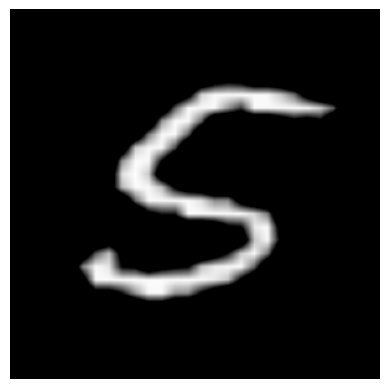

In [ ]:
# Convert the tensor image to a numpy array and transpose it to (H, W, C) format
image_np = sample_image.cpu().detach().squeeze().permute(1, 2, 0).numpy()
# image_np = spatial_data.cpu().detach().squeeze().permute(1, 2, 0).numpy()

# Reverse normalization to display the image properly
# mean = [0.5, 0.5, 0.5]
# std = [0.5, 0.5, 0.5]
# image_np = std * image_np + mean
# image_np = np.clip(image_np, 0, 1)

# Plot the image
plt.imshow(image_np)
plt.axis('off')
plt.show()

##Baseline Comparsion

##Pixel Perturbation L2 Norm Baseline

In [ ]:
sample_image.requires_grad = True
output = inception(sample_image)
loss_value = F.cross_entropy(output, label)
inception.zero_grad()
loss_value.backward()
epsilon = 0.5
perturbed_data = fgsm_attack(sample_image, epsilon, sample_image.grad.data)

pixel_features = extract_features(perturbed_data, modified_inception)

l2_norm = np.linalg.norm(baseline_features.cpu() - pixel_features.cpu())
print(l2_norm)

18.442112


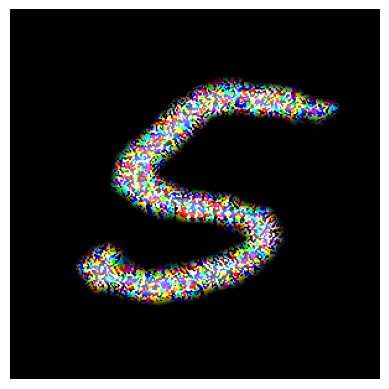

In [ ]:


# Convert the tensor image to a numpy array and transpose it to (H, W, C) format
image_np = perturbed_data.cpu().detach().squeeze().permute(1, 2, 0).numpy()

# Reverse normalization to display the image properly
# mean = [0.5, 0.5, 0.5]
# std = [0.5, 0.5, 0.5]
# image_np = std * image_np + mean
# image_np = np.clip(image_np, 0, 1)

# Plot the image
# plt.imshow(image_np)
plt.axis('off')
plt.imshow(image_np)
plt.show()

##Spatial Transformation L2 Norm Baseline

In [ ]:
hingle_flag = 1
ld_tv = 1.75
ld_adv = 3.5

num_classes = 10
inception.fc = nn.Linear(inception.fc.in_features, 10)

attack = stAdvAttack(model=inception,hingle_flag=hingle_flag, ld_tv=ld_tv, ld_adv=ld_adv)

print(sample_image)
sample_image = sample_image.to(device)
inception.zero_grad()
output = inception(sample_image)
loss_value = F.cross_entropy(output, label)
loss_value.backward()
# print(loss_value)
target_labels = np.zeros([1, num_classes], dtype = np.float32)
target_labels[:, 0] = 1
target_labels = torch.from_numpy(target_labels).cuda()
spatial_data = attack.perturb(sample_image, target_labels)

spatial_features = extract_features(spatial_data, modified_inception)

l2_norm = np.linalg.norm(baseline_features.cpu() - spatial_features.cpu())
# l2_norm = torch.norm(baseline_features.cpu() - spatial_features.cpu()).item()
print(l2_norm)

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])
tensor(2.4347, grad_fn=<AddBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor(2.4209, grad_fn=<AddBackward0>)
tensor(2.3609, grad_fn=<AddBackward0>)
tensor(2.3401, grad_fn=<AddBackward0>)
tensor(2.2933, grad_fn=<AddBackward0>)
tensor(2.2725, grad_fn=<AddBackward0>)
tensor(2.1949, grad_fn=<AddBackward0>)
tensor(2.1800, grad_fn=<AddBackward0>)
tensor(2.1301, grad_fn=<AddBackward0>)
tensor(2.1188, grad_fn=<AddBackward0>)
tensor(2.0761, grad_fn=<AddBackward0>)
tensor(1.8866, grad_fn=<AddBackward0>)
tensor(1.8509, grad_fn=<AddBackward0>)
tensor(1.7016, grad_fn=<AddBackward0>)
tensor(1.6581, grad_fn=<AddBackward0>)
tensor(1.5815, grad_fn=<AddBackward0>)
tensor(1.5565, grad_fn=<AddBackward0>)
tensor(1.5504, grad_fn=<AddBackward0>)
tensor(1.5289, grad_fn=<AddBackward0>)
tensor(1.5156, grad_fn=<AddBackward0>)
tensor(1.4589, grad_fn=<AddBackward0>)
tensor(1.4416, grad_fn=<AddBackward0>)
tensor(1.3700, grad_fn=<AddBackward0>)
tensor(1.3512, grad_fn=<AddBackward0>)
tensor(1.2750, grad_fn=<AddBackward0>)
tensor(1.2540, grad_fn=<AddBackward0>)
tensor(1.2123, grad_fn=<A

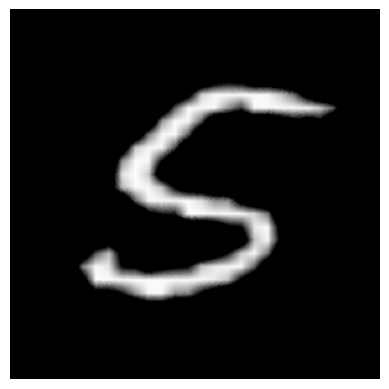

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [ ]:


# Convert the tensor image to a numpy array and transpose it to (H, W, C) format
image_np = spatial_data.cpu().detach().squeeze().permute(1, 2, 0).numpy()

# Reverse normalization to display the image properly
# mean = [0.5, 0.5, 0.5]
# std = [0.5, 0.5, 0.5]
# image_np = std * image_np + mean
# image_np = np.clip(image_np, 0, 1)

# Plot the image
plt.imshow(image_np)
plt.axis('off')
plt.show()
print(target_labels)

#VGG Training MNIST

In [ ]:
# transform = transforms.Compose([
#     transforms.Resize((224,224)),  # Resize to match ResNet input size
#     transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

train = datasets.CIFAR10(root="./data", train = True, download=True, transform= transform)
test = datasets.CIFAR10(root="./data", train = False, download=True, transform= transform)
trainData = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True, generator=torch.Generator(device))
testData = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False, generator=torch.Generator(device))

vgg = models.vgg16(pretrained=True).to(device)
num_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(num_features, 10)
vgg.eval()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print('Training....')
total = 0
correct = 0
vgg.eval()

for epoch in range(5):
    for i, data in enumerate(trainData, 1):
        images, labels = data

        if(torch.cuda.is_available()):
            images = images.cuda()
            labels = labels.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = vgg(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        if(i%100 == 0):
            print('Epoch: {} Batch: {} loss: {}'.format(epoch, i, loss.item()))

        loss.backward()
        optimizer.step()


print('Training accuracy: {} %'.format((correct/total)*100))

Training....
Epoch: 0 Batch: 100 loss: 0.9978318810462952
Epoch: 0 Batch: 200 loss: 1.0150480270385742
Epoch: 0 Batch: 300 loss: 0.6478760838508606
Epoch: 0 Batch: 400 loss: 0.7014927864074707
Epoch: 0 Batch: 500 loss: 0.7224909663200378
Epoch: 0 Batch: 600 loss: 0.513708233833313
Epoch: 0 Batch: 700 loss: 0.5779485702514648
Epoch: 1 Batch: 100 loss: 0.3945143222808838
Epoch: 1 Batch: 200 loss: 0.47037914395332336
Epoch: 1 Batch: 300 loss: 0.6665573716163635
Epoch: 1 Batch: 400 loss: 0.6191707849502563
Epoch: 1 Batch: 500 loss: 0.285286545753479
Epoch: 1 Batch: 600 loss: 0.5196205377578735
Epoch: 1 Batch: 700 loss: 0.2836129069328308
Epoch: 2 Batch: 100 loss: 0.3812943994998932
Epoch: 2 Batch: 200 loss: 0.44466471672058105
Epoch: 2 Batch: 300 loss: 0.4815536141395569
Epoch: 2 Batch: 400 loss: 0.5336852669715881
Epoch: 2 Batch: 500 loss: 0.3264786899089813
Epoch: 2 Batch: 600 loss: 0.6629942655563354
Epoch: 2 Batch: 700 loss: 0.4596230089664459
Epoch: 3 Batch: 100 loss: 0.31870329380035

In [ ]:
total = 0
correct = 0
for i, data in enumerate(testData, 1):
        images, labels = data

        if(torch.cuda.is_available()):
            images = images.cuda()
            labels = labels.cuda()
        outputs = vgg(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Training accuracy: {} %'.format((correct/total)*100))

Training accuracy: 86.79 %


In [ ]:
torch.save(vgg.state_dict(), 'vgg_MNIST.pth')

## FGSM on VGG

In [ ]:
# Load MNIST dataset
num_images = 100
subset_sampler =  torch.utils.data.SubsetRandomSampler(range(num_images))

# Create a DataLoader with the subset sampler
perturbed_test = torch.utils.data.DataLoader(test, batch_size=1, sampler=subset_sampler, generator=torch.Generator(device))
correct = 0
total = 0
epsilon = 0.5
array = [0.1,0.3,0.5]
for element in array:
  epsilon = element
  for data in perturbed_test:
    X, y = data
    X = X.to(device)
    X.requires_grad = True
    vgg.zero_grad()
    cnnOut = vgg(X)
    loss = F.cross_entropy(cnnOut, y)
    loss.backward()
    perturbed_data = fgsm_attack(X, epsilon, X.grad.data)
    output = vgg(perturbed_data)
    for index, i in enumerate(output):
      if torch.argmax(i) == y[index]:
        correct += 1
      total += 1
  print(f'Epilson: {epsilon}')
  print(f'Predicting Accuracy: {correct / total}')

Epilson: 0.1
Predicting Accuracy: 0.23
Epilson: 0.3
Predicting Accuracy: 0.22
Epilson: 0.5
Predicting Accuracy: 0.20666666666666667


##Spatial Attack on VGG

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to match ResNet input size
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load MNIST dataset
num_images = 100
subset_sampler =  torch.utils.data.SubsetRandomSampler(range(num_images))

# Create a DataLoader with the subset sampler
spatial_test = torch.utils.data.DataLoader(test, batch_size=1, sampler=subset_sampler, generator=torch.Generator(device))
# spatial_test = torch.utils.data.DataLoader(mnist_dataset, batch_size=10, shuffle=True, generator=torch.Generator(device))
print(len(spatial_test))

num_classes=10
hingle_flag = 1
ld_tv_arr = [.14,.3,1.75]
ld_adv_arr = [.6,1,3.5]
for i in range(1):
  ld_tv = 1.75
  ld_adv = 3.5
  attack = stAdvAttack(model=vgg,hingle_flag=hingle_flag, ld_tv=ld_tv, ld_adv=ld_adv)

  correct = 0
  total = 0
  for data in spatial_test:
    X, y = data
    X = X.to(device)
    vgg.zero_grad()
    cnnOut = vgg(X)
    loss = F.cross_entropy(cnnOut, y)
    loss.backward()
    target_labels = np.zeros([1, num_classes], dtype = np.float32)
    target_labels[:, 0] = 1
    target_labels = torch.from_numpy(target_labels).cuda()
    perturbed_data = attack.perturb(X, target_labels)
    output = vgg(perturbed_data)
    for index, i in enumerate(output):
      if torch.argmax(i) == y[index]:
        correct += 1
      total += 1
  print(f'LD_TV: {ld_tv} LD_ADV: {ld_adv}')
  print(f'Predicting Accuracy: {correct / total}')

100
LD_TV: 1.75 LD_ADV: 3.5
Predicting Accuracy: 0.11


##Feature Extration